In [1]:
import json
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Task 1 - Data preparation and exploration

In [2]:
# Load the datas and transform them into pd.Dataframe
df_dataset = pd.DataFrame(columns=["text", "label"])

with open("datasets/emotion_dataset.txt", "r") as datafile:
    i = 0
    for line in datafile:
        json_line = json.loads(line.strip())

        # Assert every label associated to a tweet belongs to the expected interval
        assert(0 <= json_line["label"] and json_line["label"] <= 5)

        df_dataset.loc[i] = [json_line["text"], json_line["label"]]

        i += 1


df_dataset

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
4995,i know that this pair of socks took about two ...,3
4996,i can feel the frantic beat of his heart but c...,4
4997,during lectures,1
4998,i did feel a little lighter in spirit now that...,3


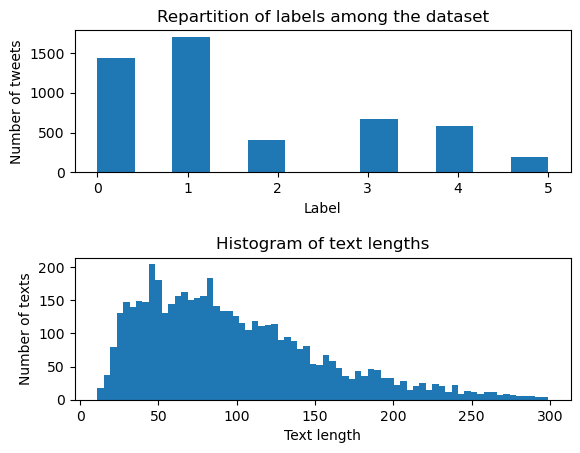

In [3]:
# Some funny plots
plt.figure()

plt.subplot(2,1,1)
plt.hist(df_dataset["label"].values, bins=12)
plt.xlabel("Label")
plt.ylabel("Number of tweets")
plt.title("Repartition of labels among the dataset")

plt.subplot(2,1,2)
plt.hist([len(text) for text in df_dataset["text"].values], bins=70)
plt.xlabel("Text length")
plt.ylabel("Number of texts")
plt.title("Histogram of text lengths")

plt.subplots_adjust(hspace=0.6)

plt.show()

In [4]:
if 0:
    # Transform the datas into suitable format for machine learning
    nlp = spacy.load("en_core_web_sm")
    lemmatized_texts = []

    for index, row in df_dataset.iterrows():
        text = row["text"]

        # Sentence lemmatization
        doc = nlp(text)
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))

    df_dataset["lemmatized_text"] = lemmatized_texts
    df_dataset.to_csv("df_emotion_dataset.csv", index=False)

In [5]:
# Open the previously created dataset with lemmatized tweets
df_dataset = pd.read_csv("datasets/df_emotion_dataset.csv")

x = df_dataset["lemmatized_text"]
y = df_dataset["label"]

# Create a CountVectorizer Object
vectorizer = CountVectorizer()

# Fit and transform the corpus with bag of word method
x = vectorizer.fit_transform(x)

# Split the dataset into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=12)

# Task 2 - Basic machine learning

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

Let first try to use the most basic machine learning classifier (majority classifier) to see what is the lower accuracy limit.

In [7]:
# Majority classifier
predicted_labels = [y_train.value_counts().idxmax()]*len(y_test)
accuracy_majority = accuracy_score(y_test, predicted_labels)
print("Majority classifier accuracy:", accuracy_majority)

Majority classifier accuracy: 0.32


## Cross validation and hyperparameters tunning

We have then tried several other methods to see how they improve the previous results.

For each method, we first computed the "raw" predictions by training the default version of the model over our dataset before testing it on the test set. Then we **tuned the hyperparameters** before training then computing the predictions again.

The methods were finally evaluated using the **cross-validation** method.

In [9]:
def cross_validation_eval(X_train, y_train, classifier, folds=5):
    """
    Test an already trained model using the cross validation pipeline.
    
    Parameters:
    X_train : the training datas without labels
    y_train : the labels of the training datas
    classifier : the model we want to evaluate
    folds : number of subgroups in which we divide the training dataset 

    """
    # Create a copy of training data
    X_cv = X_train.copy()
    y_cv = y_train.copy()

    # Initialize variables to store fold-specific evaluation metrics
    fold_eval = []

    # Initialize k-fold cross-validation
    # This implementation (*Stratified*KFolds) respects the class proportion among each folds
    skfolds = StratifiedKFold(n_splits=folds, shuffle=True)

    for _, (train_index, test_index) in enumerate(skfolds.split(X_cv, y_cv)):
        # Select data from train and test based on indices provided by kfold
        X_cv_train, X_cv_test = X_cv[train_index], X_cv[test_index]
        y_cv_train, y_cv_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

        # Train the classifier
        classifier.fit(X_cv_train, y_cv_train)

        # Predict on the test set
        y_cv_pred = classifier.predict(X_cv_test)

        # Compute the accuracy metric for this fold
        accuracy = accuracy_score(y_cv_test, y_cv_pred)
        fold_eval.append(accuracy)

    # Calculate the mean performance across all folds for this k
    mean_accuracy = np.mean(fold_eval)

    return mean_accuracy

In [10]:
def hyperparameter_tuning(X_train, y_train, model, parameters_range):
    """
    Hyperparameter tuning using Grid Search
    
    Parameters:
    X_train : the training datas unlabeled
    y_train : the corresponding labels
    model : the model we want to tune the parameters
    parameters_range (dict) : range of possible value for parameter n_neighbors

    Return:
    best_model : the model trained with the best set of parameters
    best_val : the corresponding values that train the model best
    """
    grid_search = GridSearchCV(model, parameters_range, cv=5, verbose=1) # cv = nb of folds in cross-validation evaluation
    grid_search.fit(X_train, y_train)

    # Get the best model and corresponding values
    best_model = grid_search.best_estimator_
    best_val = {}
    for param in parameters_range.keys():
        best_val[param] = grid_search.best_params_[param]

    return best_model, best_val

In [37]:
average_acc_diff = 0

## K Nearest Neighboors

In [12]:
# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_rec = (recall_score(y_test, knn_pred, average="macro")) 
knn_f1 = (f1_score(y_test, knn_pred, average="macro"))
print("KNN accuracy, recall and F1-score:", knn_acc, knn_rec, knn_f1)

KNN accuracy, recall and F1-score: 0.3368 0.20468129905366292 0.18884826496166074
5


In [13]:
# Hyperparameters tunning
knn_param = {"n_neighbors" : [i for i in range(3, 30)]}
best_knn_neighbors = hyperparameter_tuning(X_train, y_train, KNeighborsClassifier(), knn_param)[1]["n_neighbors"]
print("Best value for n_neighbors :", best_knn_neighbors)

tuned_knn = KNeighborsClassifier(n_neighbors=best_knn_neighbors)
tuned_knn.fit(X_train, y_train)
tuned_knn_pred = tuned_knn.predict(X_test)
tuned_knn_acc = accuracy_score(y_test, tuned_knn_pred)
tuned_knn_rec = recall_score(y_test, tuned_knn_pred, average="macro")
tuned_knn_f1 = f1_score(y_test, tuned_knn_pred, average="macro")
print("Tuned KNN accuracy, recall and F1-score:", tuned_knn_acc, tuned_knn_rec, tuned_knn_f1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best value for n_neighbors : 21
Tuned KNN accuracy, recall and F1-score: 0.3552 0.2019620261601711 0.16515022161068746


In [38]:
average_acc_diff += (tuned_knn_acc - knn_acc)
# Cross validation
print("The average score of KNN model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, tuned_knn))

The average score of KNN model for cross validation evaluation is : 0.35491741623104495


## Decision Tree

In [15]:
# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
dec_tree_pred = dec_tree.predict(X_test)
dec_tree_acc = accuracy_score(y_test, dec_tree_pred)
dec_tree_rec = recall_score(y_test, dec_tree_pred, average="macro")
dec_tree_f1 = f1_score(y_test, dec_tree_pred, average="macro")
print("Decision tree depth =", dec_tree.get_depth())
print("Decision Tree accuracy, recall and F1-score:", dec_tree_acc, dec_tree_rec, dec_tree_f1)

Decision tree depth = 303
Decision Tree accuracy, recall and F1-score: 0.7576 0.7248068164311493 0.7367054633352835


In [16]:
# Hyperparameter tuning
decision_tree_param = {"splitter" : ["best", "random"], "max_depth": list(250 + 10*i for i in range(0,10))}
tuned_dec_tree_params = hyperparameter_tuning(X_train, y_train, DecisionTreeClassifier(), decision_tree_param)[1]

tuned_dec_tree = DecisionTreeClassifier(splitter=tuned_dec_tree_params["splitter"], max_depth=tuned_dec_tree_params["max_depth"])
tuned_dec_tree.fit(X_train, y_train)
tuned_dec_tree_pred = dec_tree.predict(X_test)
tuned_dec_tree_acc = accuracy_score(y_test, tuned_dec_tree_pred)
tuned_dec_tree_rec = recall_score(y_test, tuned_dec_tree_pred, average="macro") 
tuned_dec_tree_f1 = f1_score(y_test, tuned_dec_tree_pred, average="macro")
print("Tuned Decision Tree accuracy, recall and F1-score:", tuned_dec_tree_acc, tuned_dec_tree_rec, tuned_dec_tree_f1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned Decision Tree accuracy, recall and F1-score: 0.7576 0.7248068164311493 0.7367054633352835


In [39]:
average_acc_diff += (tuned_dec_tree_acc - dec_tree_acc)
# Cross validation
print("The average score of Decision Tree model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, tuned_dec_tree))

The average score of Decision Tree model for cross validation evaluation is : 0.71553194313635


## Random Forest

In [18]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred, average="macro")
rf_f1 = f1_score(y_test, rf_pred, average="macro")
print("Random Forest Accuracy, Recall and F1:", rf_acc, rf_rec, rf_f1)

Random Forest Accuracy, Recall and F1: 0.712 0.6285056727723108 0.6720114964303994


In [19]:
# Hyperparameter tuning
rf_param = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
tuned_rf_param = hyperparameter_tuning(X_train, y_train, RandomForestClassifier(), rf_param)[1]

tuned_rf = RandomForestClassifier(n_estimators=tuned_rf_param["n_estimators"], 
                                  max_depth=tuned_rf_param["max_depth"],
                                  max_features=tuned_rf_param["max_features"],
                                  min_samples_split=tuned_rf_param["min_samples_split"],
                                  min_samples_leaf=tuned_rf_param["min_samples_leaf"])
tuned_rf.fit(X_train, y_train)
tuned_rf_pred = tuned_rf.predict(X_test)
tuned_rf_acc = accuracy_score(y_test, tuned_rf_pred)
tuned_rf_rec = recall_score(y_test, tuned_rf_pred, average="macro")
tuned_rf_f1 = f1_score(y_test, tuned_rf_pred, average="macro")
print("Tuned Random Forest Accuracy, Recall and F1:", tuned_rf_acc, tuned_rf_rec, tuned_rf_f1)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuned Random Forest Accuracy, Recall and F1: 0.7152 0.6414863615631131 0.6772862787818564


In [41]:
average_acc_diff += (tuned_rf_acc - rf_acc)
# Cross validation
print("The average score of Random Forest model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, tuned_rf))

The average score of Random Forest model for cross validation evaluation is : 0.6778107874060544


## Bagging

In [32]:
# Bagging
model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20, random_state=42)
model_bagging.fit(X_train, y_train)
bagging_pred = model_bagging.predict(X_test)
bagging_acc = accuracy_score(y_test, bagging_pred)
bagging_rec = recall_score(y_test, bagging_pred, average="macro")
bagging_f1 = f1_score(y_test, bagging_pred, average="macro")
print("Bagging Accuracy, Recall and F1:", bagging_acc, bagging_rec, bagging_f1)

Bagging Accuracy, Recall and F1: 0.7616 0.7162017243032323 0.7387969364960116


In [46]:
# Hyperparameter tuning
bagging_param = {
    'n_estimators': [10, 20, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}
tuned_bagging_param = hyperparameter_tuning(X_train, y_train, BaggingClassifier(), bagging_param)[1]

tuned_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                  n_estimators=tuned_bagging_param["n_estimators"], 
                                  max_samples=tuned_bagging_param["max_samples"],
                                  max_features=tuned_bagging_param["max_features"])
tuned_bagging.fit(X_train, y_train)
tuned_bagging_pred = tuned_bagging.predict(X_test)
tuned_bagging_acc = accuracy_score(y_test, tuned_bagging_pred)
tuned_bagging_rec = recall_score(y_test, tuned_bagging_pred, average="macro")
tuned_bagging_f1 = f1_score(y_test, tuned_bagging_pred, average="macro")
print("Bagging Accuracy, Recall and F1:", tuned_bagging_acc, tuned_bagging_rec, tuned_bagging_f1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
average_acc_diff += (tuned_bagging_acc - bagging_acc)
# Cross validation
print("The average score of Bagging model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, tuned_bagging))

The average score of Bagging model for cross validation evaluation is : 0.6962914736130161


## Boosting

In [24]:
# Boosting
model_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier())
model_boosting.fit(X_train, y_train)
boosting_pred = model_boosting.predict(X_test)
boosting_acc = accuracy_score(y_test, boosting_pred)
boosting_rec = recall_score(y_test, boosting_pred, average="macro")
boosting_f1 = f1_score(y_test, boosting_pred, average="macro")
print("Boosting Accuracy, Recall and F1:", boosting_acc, boosting_rec, boosting_f1)

/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Boosting Accuracy, Recall and F1: 0.744 0.7243171364041712 0.7288727013102511
1.0


In [25]:
# Hyperparameter tuning
boosting_param = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
}

tuned_boosting_param = hyperparameter_tuning(X_train, y_train, AdaBoostClassifier(estimator=DecisionTreeClassifier()), boosting_param)[1]
print(tuned_boosting_param)
tuned_boosting = AdaBoostClassifier(estimator = DecisionTreeClassifier(),
                                    n_estimators=tuned_boosting_param["n_estimators"],
                                    learning_rate=tuned_boosting_param["learning_rate"])

tuned_boosting.fit(X_train, y_train)
tuned_boosting_pred = tuned_boosting.predict(X_test)
tuned_boosting_acc = accuracy_score(y_test, tuned_boosting_pred)
tuned_boosting_rec = recall_score(y_test, tuned_boosting_pred, average="macro")
tuned_boosting_f1 = f1_score(y_test, tuned_boosting_pred, average="macro")
print("Tuned Boosting Accuracy, Recall and F1:", tuned_boosting_acc, tuned_boosting_rec, tuned_boosting_f1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

{'n_estimators': 100, 'learning_rate': 0.5}


/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Tuned Boosting Accuracy, Recall and F1: 0.76 0.7393316147816726 0.7424455107675763


In [43]:
average_acc_diff += (tuned_boosting_acc - boosting_acc)
# Cross validation
print("The average score of Boosting model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, tuned_boosting))

/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

The average score of Boosting model for cross validation evaluation is : 0.6970474643337988


In [ ]:
print("The mean difference in accuracies between raw and hyperparameter tuned models is ", average_acc_diff/5)

The mean difference in accuracies between raw and hyperparameter tuned models is  0.004159999999999997


## Neural network with pretrained sentence embedding 

In this section, we explore more sophisticated deep learning techniques to enhance our classification performance. 

Our approach leverages pre-trained sentence embeddings using the Sentence Transformers library from Hugging Face. We selected the `all-MiniLM-L6-v2` model for its ability to transform complete sentences into rich, contextual vector representations.

The model processes each input sentence and generates a fixed-length vector of 384 dimensions, capturing the semantic meaning and contextual relationships within the text. 

These embeddings will be our starting point to explore how we can use deeplearning approaches to adress this challenge of emotion classification

### Loading the Data and Using the Model

The following class provides a convenient method for preprocessing the data. It begins by reading a CSV file containing sentences and their associated labels. 

Next, the class splits the dataset into two subsets: 80% for training and 20% for evaluation. 

Finally, it returns DataLoaders (training and eval), which are particularly useful for training models in PyTorch by efficiently managing data batching and shuffling.


In [1]:
from datasets import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch

class EmotionDataLoader:
    def __init__(self, csv_path, model_name='all-MiniLM-L6-v2', batch_size=16):
        """
        Initialize the data loader with a more sophisticated embedding model.
        
        Args:
            csv_path: Path to the CSV file containing text and labels
            model_name: SentenceTransformer model to use for embeddings
            batch_size: Batch size for DataLoader
        """
        self.csv_path = csv_path
        self.batch_size = batch_size
        # Initialize the sentence transformer model
        self.embedding_model = SentenceTransformer(model_name)
        # Set embedding dimension based on model
        self.embedding_dim = self.embedding_model.get_sentence_embedding_dimension()
        
    def load_data(self):
        """Load and split the data"""
        df = pd.read_csv(self.csv_path)
        train_df, val_df = train_test_split(
            df, 
            test_size=0.2, 
            random_state=42, 
            stratify=df['label']
        )
        return train_df, val_df
    
    def generate_embeddings(self, texts):
        """
        Generate embeddings for a list of texts using SentenceTransformer.
        Returns tensor of shape (n_texts, embedding_dim)
        """
        with torch.no_grad():
            embeddings = self.embedding_model.encode(
                texts,
                batch_size=self.batch_size,
                show_progress_bar=False,
                convert_to_tensor=True
            )
        return embeddings
    
    def create_dataset(self, df):
        """Create a PyTorch dataset from DataFrame with embeddings"""
        # Generate embeddings for all texts
        embeddings = self.generate_embeddings(df['text'].tolist())
        labels = torch.tensor(df['label'].values)
        
        # Create TensorDataset
        dataset = torch.utils.data.TensorDataset(embeddings, labels)
        return dataset
    
    def prepare_dataloader(self):
        """Prepare train and validation dataloaders with embeddings"""
        # Load and split data
        train_df, val_df = self.load_data()
        
        # Create datasets with embeddings
        train_dataset = self.create_dataset(train_df)
        val_dataset = self.create_dataset(val_df)
        
        # Create DataLoaders
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        return train_dataloader, val_dataloader, self.embedding_dim

/Users/luc/miniconda3/envs/intSyst/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training Models 

The following function is a generic implementation to train a given model for our problem.
The function is designed to compute and plot the evolution of loss and accuracy over epochs. Here's a detailed breakdown:

- **Inputs**:
  - `model`: The PyTorch model to be trained.
  - `train_dataloader`: DataLoader for the training dataset.
  - `val_dataloader`: DataLoader for the validation dataset.
  - `device`: The device (CPU or GPU) to perform the computations on.
  - `num_epochs` (default=100): The number of epochs for training.
  - `lr` (default=1e-3): The learning rate for the optimizer.

- **Functionality**:
  1. Initializes the loss function (`nn.CrossEntropyLoss`) and the optimizer (`torch.optim.Adam`).
  2. Tracks the training loss, validation loss, and validation accuracy for each epoch.
  3. Iterates over the specified number of epochs:
     - In the **training phase**, the function computes the loss, performs backpropagation, and updates the model's weights.
     - In the **validation phase**, the function evaluates the model without gradient computations, calculating both validation loss and accuracy.
  4. Appends training loss, validation loss, and accuracy values for each epoch to track their evolution.
  5. Plots the training and validation losses as well as the validation accuracy to visualize the model's performance.

- **Outputs**:
  - Returns the final validation accuracy after training.


In [2]:
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

def train(model, train_dataloader, val_dataloader, device, num_epochs=100, lr=1e-3):
    """Train the model and plot loss evolution with progress bars"""
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    trainings_loss = []
    val_loss = []
    accuracy = []

    # Training loop with tqdm for progress tracking
    for epoch in tqdm(range(num_epochs), desc="Epochs", leave=False):
        model.train()
        
        # Train data progress bar
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        trainings_loss.append(loss.item())

        # Validation loss and accuracy
        model.eval()
        val_loss_temp = []
        temp_accuracy = []
        
        # Validation data progress bar
        for inputs, labels in tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            # Compute accuracy
            predicted = torch.argmax(outputs, dim=1)
            temp_accuracy.append((predicted == labels).sum().item() / len(labels))
            loss = criterion(outputs, labels)
            val_loss_temp.append(loss.item())

        accuracy.append(np.mean(temp_accuracy))
        val_loss.append(np.mean(val_loss_temp))

    # Plot loss evolution (training and validation)
    plt.plot(trainings_loss)
    plt.plot(val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss evolution')
    plt.legend(['Training', 'Validation'])

    # Plot accuracy evolution
    plt.figure()
    plt.plot(accuracy)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution')

    return accuracy[-1]


### Exploring Multilayer Perceptron Models

In this section, we examined the performance of multilayer perceptrons, progressing from a simple model to deeper neural networks.

In [3]:
# This block is used to define the different models we will use
import torch
import torch.nn as nn
from transformers import AutoModel

class SimpleLinearClassifier(nn.Module):
    def __init__(self, input_size=128, num_classes=6):
        super().__init__()
        self.classifier = nn.Linear(input_size, num_classes)
        
    
    def forward(self, x):
        x = x.to(torch.float32)
        return self.classifier(x)
    

class model2(nn.Module):
    def __init__(self, input_size=128, num_classes=6):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        x = x.to(torch.float32)
        return self.linear2(self.relu(self.linear1(x)))
    

class model3(nn.Module):
    def __init__(self, input_size=128, num_classes=6, dropout_rate=0.5):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8*input_size)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(8*input_size, 4*input_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.final = nn.Linear(4*input_size, num_classes)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)  
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)  
        return self.final(x)


##### Unified Wrapper Function for Model Training

The following function serves as a comprehensive wrapper, combining data preparation, model initialization, and training into a single call. This simplifies the process, allowing the implementation and training of a model with just one line of code.


In [4]:
def wrapper(csv_path, model_name='all-MiniLM-L6-v2', batch_size=16, model_class=model3, num_classes=6, num_epochs=10, lr=1e-4):
    """
    Prepares data, initializes the model, and trains it on the emotion dataset.

    Args:
        csv_path (str): Path to the dataset CSV file.
        model_name (str): Name of the embedding model to use.
        batch_size (int): Batch size for the dataloader.
        model_class (nn.Module): The model class to instantiate.
        num_classes (int): Number of target classes.
        num_epochs (int): Number of epochs for training.
        lr (float): Learning rate for training.

    Returns:
        Trained model and training results.
    """
    # Determine device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    # Load the data
    data_loader = EmotionDataLoader(
        csv_path=csv_path,
        model_name=model_name,
        batch_size=batch_size
    )
    train_dataloader, val_dataloader, emb_size = data_loader.prepare_dataloader()

    # Initialize the model
    model = model_class(input_size=emb_size, num_classes=num_classes)
    model.to(device)

    # Train the model
    final_accuracy = train(model, train_dataloader, val_dataloader, num_epochs=num_epochs, lr=lr, device=device)

    return model, final_accuracy


#### 1. **SimpleLinearClassifier**
A basic model with a single linear layer mapping inputs to outputs. 

(SimpleLinearClassifier(
   (classifier): Linear(in_features=384, out_features=6, bias=True)
 ),
 0.6458333333333334)

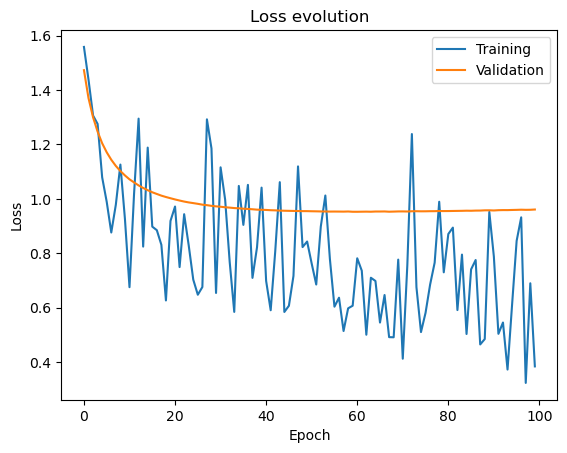

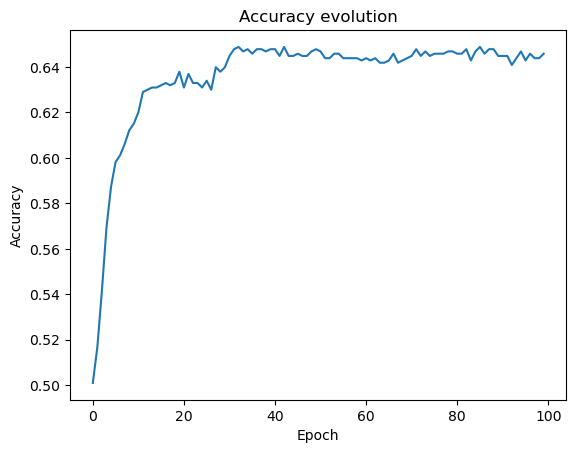

In [5]:
wrapper("datasets/df_emotion_dataset.csv", model_class=SimpleLinearClassifier, num_epochs=100, lr=1e-3)

##### Analysis:
With 100 epochs and a learning rate of 1e-4, the model achieves 61% accuracy.
By testing and varying the learning rate and the number of epochs, it does not seem to significantly improve the performance.


#### **2. Model2**

A neural network with two fully connected layers and a ReLU activation function. It takes an input of size `input_size`  and outputs predictions of size `num_classes`

(model2(
   (linear1): Linear(in_features=384, out_features=512, bias=True)
   (relu): ReLU()
   (linear2): Linear(in_features=512, out_features=6, bias=True)
 ),
 0.6795634920634921)

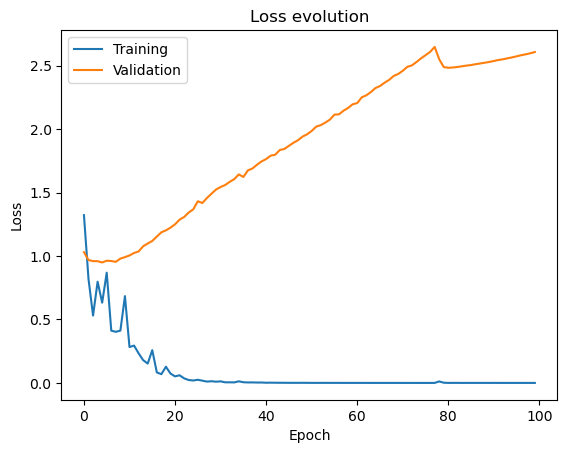

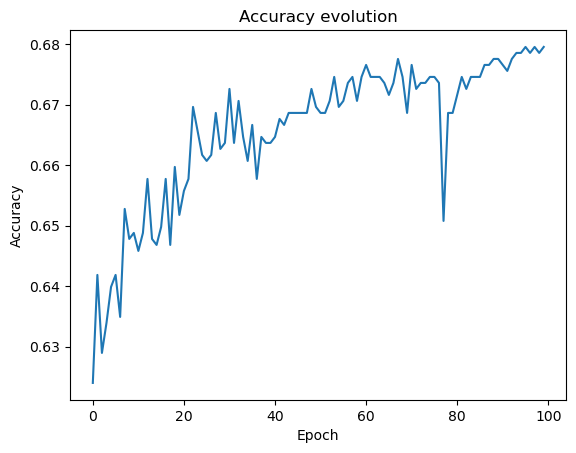

In [6]:
wrapper("datasets/df_emotion_dataset.csv", model_class=model2, num_epochs=100, lr=1e-3)

##### Analysis

The model achieved an accuracy of 66% on the evaluation set. However, the increasing validation loss over epochs indicates overfitting. To address this, we plan to experiment with a larger dataset and incorporate dropout in future models.


#### **3. Model3**

The `model3` is a fully connected neural network with two hidden layers, incorporating dropout regularization to combat overfitting we observed witht the previous model.

 The architecture includes:
- The first hidden layer transforms the input to 8 times the input size, followed by ReLU activation and dropout.
- The second hidden layer reduces the dimensionality to 4 times the input size, again with ReLU activation and dropout.
- The output layer maps the features to the final number of classes (6 in this case).

Dropout is applied after each hidden layer with a configurable dropout rate, helping to prevent overfitting during training.


(model3(
   (linear1): Linear(in_features=384, out_features=3072, bias=True)
   (relu): ReLU()
   (dropout1): Dropout(p=0.5, inplace=False)
   (linear2): Linear(in_features=3072, out_features=1536, bias=True)
   (dropout2): Dropout(p=0.5, inplace=False)
   (final): Linear(in_features=1536, out_features=6, bias=True)
 ),
 0.6765873015873016)

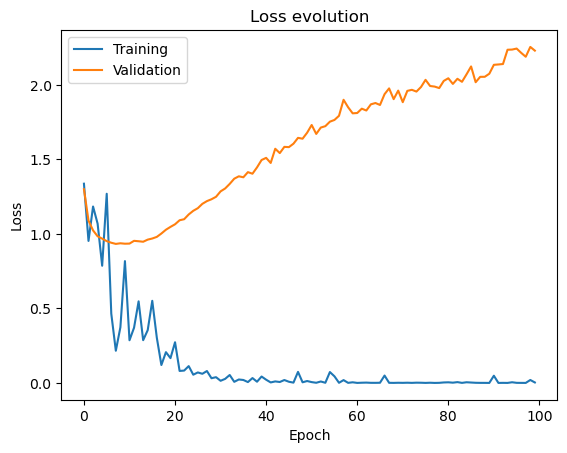

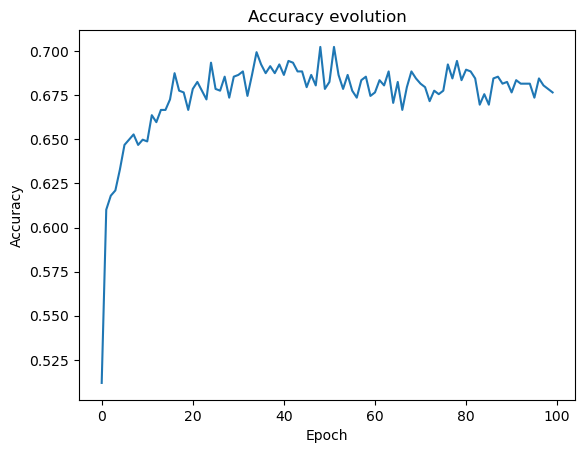

In [7]:
wrapper("datasets/df_emotion_dataset.csv", model_class=model3, num_epochs=100, lr=1e-4)

##### Analysis  
This time, we used a learning rate of 1e-4 because of the increase in complexity of the model. 
The model achieved an accuracy of `70%` on the evaluation set. However, we still can still observe some overfitting 

#### Dataset Expansion

To improve performance and mitigate overfitting observed in previous models, we opted to use a larger dataset. We found a dataset on Kaggle (https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data) that use the same the structure of the original dataset but is much larger, providing more diverse examples for training.

Because the number of example is very large (393,822 samples) we only use a fraction of it.
Let's for example start by using 5% of this dataset 


The following function is used to read the big dataset and pick fraction of it and save it as a new dataset

In [8]:
def extract_csv_fraction(input_file, output_file, fraction=0.10, random=True):
    """
    Extract a fraction of rows from a CSV file and save it to a new file.

    Parameters:
        input_file (str): Path to the input CSV file.
        output_file (str): Path to save the reduced CSV file.
        fraction (float): Fraction of rows to extract (default is 10%).
        random (bool): Whether to sample rows randomly (default is True).
    """
    # Load the CSV file
    print(f"Loading the CSV file: {input_file}")
    data = pd.read_csv(input_file)
    
    # Extract a fraction of the data
    if random:
        sampled_data = data.sample(frac=fraction, random_state=42)  # Random sampling
    else:
        sampled_data = data.head(int(len(data) * fraction))  # Take top rows
    
    # drop the column unmaed
    sampled_data = sampled_data.drop(columns=sampled_data.columns[0])
    # Save the sampled data to a new file
    sampled_data.to_csv(output_file, index=False)
    print(f"Saved {fraction*100}% of the data to: {output_file}")
    

In [9]:
# generating the new dataset
extract_csv_fraction("datasets/big_dataset.csv", "datasets/df_emotion_dataset_05.csv", fraction=0.05, random=True)

Loading the CSV file: datasets/big_dataset.csv
Saved 5.0% of the data to: datasets/df_emotion_dataset_05.csv


In [10]:
extract_csv_fraction("datasets/big_dataset.csv", "datasets/df_emotion_dataset_10.csv", fraction=0.10, random=True)

Loading the CSV file: datasets/big_dataset.csv
Saved 10.0% of the data to: datasets/df_emotion_dataset_10.csv


#### Training the model on the new dataset 5%

We trained `model3` using the larger dataset from Kaggle. Given the increased size of the dataset, we reduced the number of epochs

In [11]:
# here we redefine model3 to be sure we start from scratch
class model3(nn.Module):
    def __init__(self, input_size=128, num_classes=6, dropout_rate=0.5):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8*input_size)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(8*input_size, 4*input_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.final = nn.Linear(4*input_size, num_classes)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)  
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)  
        return self.final(x)

Accuracy on the validation set: 0.7409003831417624


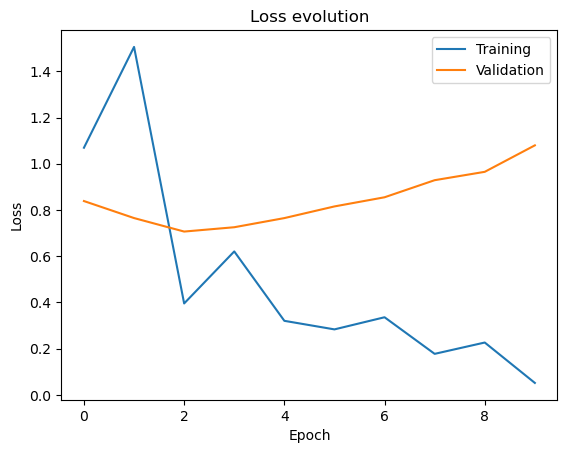

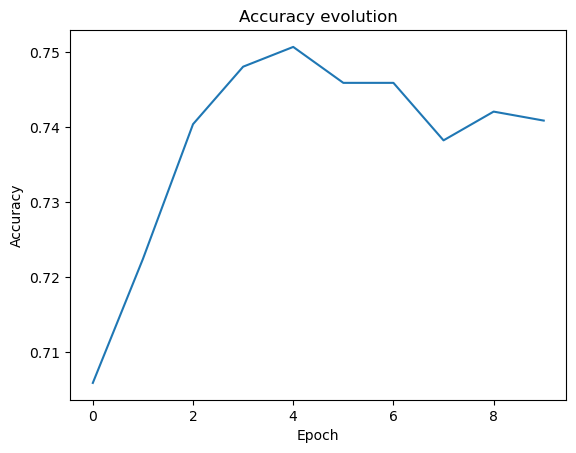

In [13]:
model, acc = wrapper("datasets/df_emotion_dataset_05.csv", model_class=model3, num_epochs=10, lr=1e-3)
print(f"Accuracy on the validation set: {acc}")

#### Training the model on 10% of the big dataset


In [69]:
# here we redefine model3 to be sure we start from scratch
class model3(nn.Module):
    def __init__(self, input_size=128, num_classes=6, dropout_rate=0.5):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8*input_size)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(8*input_size, 4*input_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.final = nn.Linear(4*input_size, num_classes)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)  
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)  
        return self.final(x)

In [ ]:
model, acc = wrapper("datasets/df_emotion_dataset_50.csv", model_class=model3, num_epochs=10, lr=1e-3)
print(f"Accuracy on the validation set: {acc}")

##### Analysis
What we observed is that using a larger dataset significantly improved performance, reaching around `75% accuracy`.

### Testing the model on our own example

In [28]:
import torch
from sentence_transformers import SentenceTransformer

def use_with_example(model, sentence):
    """Use the model to predict the emotion of a sentence"""
    
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    # Check if the model is an instance of nn.Module
    if not isinstance(model, torch.nn.Module):
        raise ValueError("The provided model is not a valid torch.nn.Module.")
    
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Get embeddings for the sentence
    with torch.no_grad():
        embeddings = embedding_model.encode(sentence, convert_to_tensor=True)
    embeddings = embeddings.to(device)

    # Add batch dimension (required by the model)
    embeddings = embeddings.unsqueeze(0)

    # Get the model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(embeddings)

    
    # Get the predicted class (emotion)
    predicted = torch.argmax(outputs, dim=1)
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    return emotions[predicted.item()]

emotion = use_with_example(model, "I am so happy today!")
print(f"The predicted emotion is: {emotion}")




The predicted emotion is: joy


### Discussion

To summarize, we experimented with several simple fully connected classifiers using pretrained embeddings of sentences to predict emotions.

The simpler models were prone to overfitting, so we progressively applied techniques such as dropout and, more significantly, used a larger dataset, which led to improved results. While the model still exhibits some overfitting, the performance is decent reaching `75%` of accuracy

Additionally, when testing the classifier with our own example, we found that it works relatively well, particularly with simpler sentences.

To further improve results, it would likely be beneficial to explore more advanced architectures such as LSTMs or Transformers, which are better suited to handle the sequential nature of the task.

In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

def load_sentiment_model(model_name="distilbert-base-uncased-finetuned-sst-2-english"):
    """
    Load a sentiment analysis model using two methods:
    1. Using pipeline (simple)
    2. Loading model and tokenizer separately (more control)
    """
    # Method 1: Using pipeline (easier)
    classifier = pipeline("sentiment-analysis", model=model_name)
    
    # Method 2: Loading model and tokenizer separately (more control)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    return {
        "pipeline": classifier,
        "model": model,
        "tokenizer": tokenizer
    }

def analyze_sentiment_pipeline(text, classifier):
    """
    Analyze sentiment using the pipeline method
    """
    result = classifier(text)
    return result[0]

def analyze_sentiment_manual(text, model, tokenizer):
    """
    Analyze sentiment using manual method with model and tokenizer
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
    # Convert predictions to numpy for easier handling
    scores = predictions.numpy()[0]
    labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    # Get the predicted label and score
    predicted_label = labels[scores.argmax()]
    confidence = float(scores.max())
    
    return {
        "label": predicted_label,
        "score": confidence
    }

/Users/luc/miniconda3/envs/intSyst/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Finally, what if we use a pretrained transformer model 

As a bonus, we explored the use of a pretrained transformer (encoder only) model, specifically DistilBERT. We fine-tuned it on our initial dataset to evaluate the level of performance it could achieve with a modest fine_tuning (3 epochs on the original dataset)

Epochs:  33%|███▎      | 1/3 [05:04<10:08, 304.05s/it]


Epoch 1/3:
Average Training Loss: 0.7360
Average Validation Loss: 0.3266
Validation Accuracy: 0.9030
------------------------------------------------------------


Epochs:  67%|██████▋   | 2/3 [10:32<05:18, 318.68s/it]


Epoch 2/3:
Average Training Loss: 0.1940
Average Validation Loss: 0.2829
Validation Accuracy: 0.9060
------------------------------------------------------------


Epochs: 100%|██████████| 3/3 [16:02<00:00, 320.69s/it]



Epoch 3/3:
Average Training Loss: 0.1137
Average Validation Loss: 0.2789
Validation Accuracy: 0.9140
------------------------------------------------------------


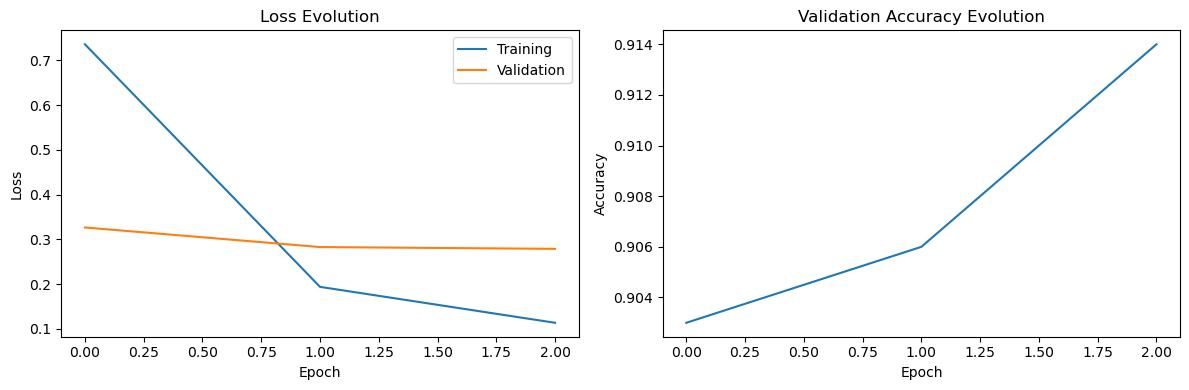

In [29]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  
        }

class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        output = outputs[0][:, 0]  
        output = self.dropout(output)
        return self.classifier(output)

def train_model(model, train_loader, val_loader, device, num_epochs=5, lr=2e-5):
    """
    Train the model with progress bars and plot loss/accuracy evolution
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    training_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", leave=True):
        model.train()
        epoch_train_losses = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_train_losses)
        training_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_losses = []
        epoch_accuracies = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device) 
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                
                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                accuracy = (predicted == labels).float().mean().item() 
                
                epoch_val_losses.append(loss.item())
                epoch_accuracies.append(accuracy)
        
        avg_val_loss = np.mean(epoch_val_losses)
        avg_accuracy = np.mean(epoch_accuracies)
        
        val_losses.append(avg_val_loss)
        accuracies.append(avg_accuracy)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {avg_accuracy:.4f}')
        print('-' * 60)
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Evolution')
    
    plt.tight_layout()
    plt.show()
    
    return accuracies[-1]

df = pd.read_csv("datasets/df_emotion_dataset.csv")


# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    df['text'].values, 
    df['label'].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = EmotionDataset(X_train, y_train, tokenizer, max_length=64)
val_dataset = EmotionDataset(X_val, y_val, tokenizer, max_length=64)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionClassifier(n_classes=6).to(device)

final_accuracy = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=3,
    lr=2e-5
)

In [ ]:
# use the model on our own sentence 
def predict_emotion(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted = torch.argmax(outputs, dim=1).item()
    
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    return emotions[predicted]

text = "I crush on you"
predict_emotion(text, model, tokenizer, device)

'love'

#### Discussion

Even with a pretrained model, we achieved only 91% accuracy, which did not meet our expectations for higher performance. Several hypotheses could explain this result: insufficient fine-tuning, the potential need for complexe architecture.

Upon closer examination, some examples in the dataset are particularly challenging to classify, which may contribute to the observed performance plateau.

Examples:

    "I feel more superior dead chicken or grieving child" → Joy
    "I feel like some of you have pains, and you cannot imagine becoming passionate about the group or the idea that is causing pain" → Love

Of course, these examples are cherry-picked, and many others are much easier to classify. However, this supports our hypothesis that the complexity of certain instances in the dataset is a key reason why the pretrained model does not achieve accuracy beyond 91%.